In [2]:
#Set up DRWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl")
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl")

return_finite_stable_boundary_extra (generic function with 1 method)

In [74]:
#compute bindoal
Pe = 7.5
γ = 1.78
find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = (1-10e-16), initial_Δ = 1e-6, max_iter = 100, tol = 1e-14) 
ϕ1 = lower_limits[1]  
ϕ2 = upper_limits[2] 

#define problem
using DifferentialEquations

function f(du,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    du[1] = Pe*(1-u[1])*u[2]
    du[2] = -Pe*u[2]^2 + Pe*( (1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1]) -(2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])
    return du
end

function f_jac(J,u,parameters,t)
    Pe = parameters[1]
    γ = parameters[2]
    ϕ1 = parameters[3]
    J[1,1] = -Pe*u[2]
    J[1,2] =  Pe*(1-u[1])
    J[2,1] =  self_diff_prime(u[1])*            (2/Pe)*log( (1-u[1])/(1-ϕ1) )/self_diff(u[1])^2              + (2/Pe)/(1-u[1])/self_diff(u[1])
    J[2,1] += self_diff_prime(u[1])*Pe*((1-γ*(1-u[1]))*self_diff(u[1]) -(1-γ*(1-ϕ1))*self_diff(ϕ1) )/self_diff(u[1])^2  + Pe*(γ*self_diff(u[1]) +(1-γ*(1-u[1]))*self_diff_prime(u[1]) )/self_diff(u[1])
    J[2,2] = -2*Pe*u[2]
    return J
end

#compute solution 
parameters = (Pe, γ, ϕ1, ϕ2)
ff = ODEFunction(f;jac=f_jac)
ϵ = 1e-15
initial_position = [ϕ1+ϵ, 0.0]
time_interval = (0.0, 20.0)

ff = ODEFunction(f;jac=f_jac)
prob = ODEProblem(ff,initial_position,time_interval, parameters)

sol = DifferentialEquations.solve(prob,abstol = 1e-12, reltol = 1e-12);

# #find central time
t_mid_arg = argmax(sol[2,:])
t_middle = sol.t[t_mid_arg]
t_max = maximum(sol.t[:].-t_middle)
t_min = minimum(sol.t[:].-t_middle)
t_lim = round(min(t_max, - t_min))
sol[1,t_mid_arg]

rho_strt = 1 #argmin(abs.(sol[1,:].-ϕ1.-0.05))
rho_end  = t_mid_arg # argmin(abs.(sol[1,:].-ϕ2.+0.05))
drho = (sol[1,(rho_strt+1):(rho_end)].-sol[1,(rho_strt):(rho_end-1)])./(sol.t[(rho_strt+1):(rho_end)].-sol.t[(rho_strt):(rho_end-1)]);
infec_pt = argmax(drho)
sol[1,rho_strt+infec_pt]

mid_av = (rho_strt+infec_pt + t_mid_arg) ÷ 2

sol[1,mid_av]

0.816079927053443

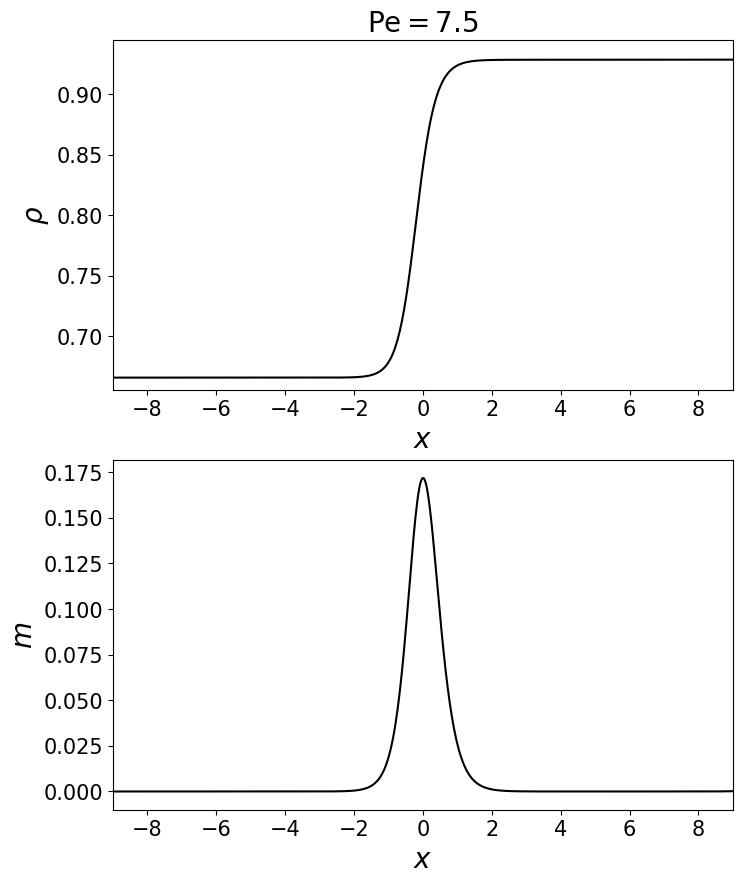

In [75]:
using PyPlot
#plot figure
PyPlot.close("all")
fig, axs = plt.subplots(2, 1, figsize=(8,10))
xlabels = [L"\rho", L"m"]
for i in 1:2
    ax = axs[i]
    ax.plot(sol.t[:].-t_middle, sol[i,:], color = "black")
    axlim = [ -t_lim, t_lim, minimum(sol[i,:])-0.01, maximum(sol[i,:])+0.01]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_ylabel(xlabels[i],fontsize=20)
    ax.set_xlabel(L"x",fontsize=20)
end
fig_title = latexstring("\$ \\mathrm{Pe} = $(Pe) \$")
axs[1].set_title(fig_title,fontsize=20)
display(fig)

In [ ]:
#save figure
name = "Sol_Pe=$(Pe)"
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)/Solution.pdf";
    PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)